
본 파일은 이기창님의 'Do it! 자연어 처리'에 기초하여 작성되었음을 미리 알려드립니다! :)

# 학습 마친 모델을 실전 투입하기

이번 실습에서는 **학습을 마친 문서 분류 모델을 가지고 웹 서비스를 만든다**.

문장을 받아 해당 문장이 긍정인지 부정인지 답변하는 웹 서비스로, 문장을 토큰화한 뒤 모델 입력값으로 만들고 이를 모델에 입력해 [*해당 문장이 긍정일 확률, 해당 문장이 부정일 확률* ]을 계산하게 만든다. 이후 약간의 후처리 과정을 거쳐 응답하게 만드는 방식이다.

웹 서비스란 네트워크에서 컴퓨터 간에 상호작용을 하기 위해 만들어진 소프트웨어 시스템이다. 본 노트에서는 원격 사용자가 보낸 문장을 수신해 해당 문장이 긍정인지 부정인지 응답을 만들고 이 응답을 원격 사용자에게 전달하는 웹 서비스를 만드는 것이다.

## 1. 환경 설정하기

### 의존성 패키지 설치

pip 명령어를 통해 의존성 있는 패키지를 설치한다.

#### code 2-0

In [1]:
!pip install ratsnlp

### 구글 드라이브 연동

모델 체크포인트는 구글 드라이브에 저장해 두었다. 코랩 노트북과 자신의 구글 드라이브를 연동한다.

#### code 2-1

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### 인퍼런스 설정

각종 인자( 모델 하이퍼파라미터(hyperparameter)와 저장 위치 등 )를 설정한다.

#### code 2-2

In [3]:
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls",
    max_seq_length=128,
)

downstream_model_checkpoint_fpath: /gdrive/My Drive/nlpbook/checkpoint-doccls/epoch=1-val_loss=0.28.ckpt


각 인자의 역할과 내용은 다음과 같다.
  
  * **pretrained_model_name**: `training_section.ipynb`에서 적용한 `pretrained_model_name`(단, 해당 모델은 허깅페이스 라이브러리에 등록되어 있어야 한다.)
  * **downstream_model_dir**:  `training_section.ipynb`에서 파인튜닝한 모델의 체크포인트 저장 위치(확장자가 `ckpt`인 파일이 하나 이상 있어야 한다.)
  * **max_seq_length**: 토큰 기준 입력 문장 최대 길이. 아무것도 입력하지 않으면 128.

## 2. 토크나이저 및 모델 불러오기

### 토크나이저 로드

code 2-3을 실행해 토크나이저를 초기화 한다.

#### code 2-3

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name,
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

### 체크포인트 로드

code 2-4는 `training_section.ipynb`에서 파인튜닝한 모델의 체크포인트를 읽어들인다.

#### code 2-4

In [5]:
import torch
fine_tuned_model_ckpt = torch.load(
    args.downstream_model_checkpoint_fpath,
    map_location=torch.device("cpu"),
)

### BERT 설정 로드 및 BERT 모델 초기화

code 2-5는 `training_section.ipynb`의 파인튜닝 때 사용한 `pretrained_model_name`에 해당하는 모델의 설정값들을 읽어들인다. 

이어서 code 2-6을 실행하면 해당 설정값대로 **BERT** 모델을 초기화 한다.

#### code 2-5

In [6]:
from transformers import BertConfig
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=fine_tuned_model_ckpt["state_dict"]["model.classifier.bias"].shape.numel(),
)

#### code 2-6

In [7]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification(pretrained_model_config)

###  체크포인트 주입하기

code 2-7은 초기화한 **BERT**모델에 체크포인트(fine_tuned_model_ckpt)를 주입한다.

#### code 2-7

In [8]:
model.load_state_dict({k.replace("model.",""): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

<All keys matched successfully>

### 평가모드로 전환

이어서 code 2-8을 실행하면 모델이 평가모드로 전환되게 된다. **드롭아웃 등 학습 때만 사용하는 기법들을 무효화하는 역할**을 한다.

#### code 2-8

In [9]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 3. 모델 출력값 만들고 후처리 하기

code 2-9는 **인퍼런스 과정을 정의한 함수**이다. 문장에 토큰화를 수행한 뒤 `input_ids`, `attention_mask`, `token_type_ids`를 만든다. 이들 입력값을 파이토치의 텐서 자료형으로 변환한 뒤 모델에 입력한다. 모델 출력값(`outputs.logits`)은 소프트맥스 함수 적용 이전의 **로짓**(logit)형태인데, 여기에 소프트맥스 함수를 써서 모델 출력을 '[**부정일 확률, 긍정일 확률**]'로 바꾼다.

마지막으로 모델 출력을 약간 후처리 하여 예측 확률의 최댓값이 부정 위치일 때 해당 문장이 '**부정**(negative)', 반대일 때는 '**긍정**(positive)'이 되도록 `pred`값을 만든다.

#### code 2-9

In [10]:
def inference_fn(sentence):
  # 문장을 토큰화한 뒤 input_id, attention_masks, token_type_ids 만들기
  inputs = tokenizer(
      [sentence],
      max_lenght=args.max_seq_length,
      padding="max_length",
      truncation=True,
  )
  with torch.no_grad():
    # 모델 계산하기
    outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})  # {}안 = inputs를 파이토치 텐서로 바꾸기
    
    # 로짓에 소프트 맥스 취하기
    prob = outputs.logits.softmax(dim=1)

    # 긍정/부정 확률을 소수점 4자리로 반올림
    positive_prob = round(prob[0][1].item(), 4)
    negative_prob = round(prob[0][0].item(), 4)

    # 예측 확률의 최댓값 위치에 따라 pred 만들기
    pred = "긍정 (positive)" if torch.argmax(prob) == 1 else "부정 (negative)"
  return {
      'sentence' : sentence,
      'prediction': pred,
      'positive_data': f"긍정 {positive_prob}",
      'negative_data': f"부정 {negative_prob}",
      'positive_width': f"{positive_prob * 100}%",
      'negative_width': f"{negative_prob * 100}%",
  }

code 2-9에서 `positive_width`, `negative_width`는 웹 페이지에서 긍정/부정 막대의 길이를 조정하려는 것이므로 크게 신경쓰지 않아도 된다.

## 4. 웹 서비스 시작하기

### 웹 서비스 만들기 준비

`ngrok`은 코랩 로컬에서 실행 중인 웹서비스를 안전하게 외부에서 접근 가능하도록 해주는 도구이다. `ngrok`을 실행하려면 [회원가입](https://dashboard.ngrok.com/get-started/setup) 후 [로그인](https://dashboard.ngrok.com/get-started/setup)을 한 뒤 [이곳](https://dashboard.ngrok.com/get-started/your-authtoken)에 접속해 인증토큰(authtoken)을 확인해야 한다. 

예를 들어 확인된 `authtoken`이 `test123`이라면 다음과 같이 실행 된다.

** !mkdir /root/.ngrok2 && echo "authtoken: test123" > /root/.ngrok2/ngrok.yml**

#### code 2-10

In [11]:
!mkdir /root/.ngrok2 && echo "authtoken: 25VlJirb2snSErokfS8Nxc52HkI_2jNyvvx1PLGurfQKXuLJC" > /root/.ngrok2/ngrok.yml

### 웹 서비스 시작하기

code 2-9에서 정의한 인퍼런스 함수 `inference_fn`을 가지고 code 2-11을 실행하면 **플라스크**(flask)라는 파이썬 라이브러리의 도움을 받아 웹 서비스를 띄울 수 있다.

#### code 2-11

In [12]:
from ratsnlp.nlpbook.classification import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()

 * Serving Flask app "ratsnlp.nlpbook.classification.deploy" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a6fd-34-86-194-28.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [23/Feb/2022 13:01:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2022 13:01:09] "GET /favicon.ico HTTP/1.1" 404 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:01:18] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:01:25] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:01:29] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:02:12] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:02:34] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:03:11] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not recognized.
127.0.0.1 - - [23/Feb/2022 13:03:35] "POST /api HTTP/1.1" 200 -
Keyword arguments {'max_lenght': 128} not r

## 서비스를 실행한 결과는 아래와 같다. 밑에서 두번째 줄을 클릭하면 웹 사이트로 연결된다.

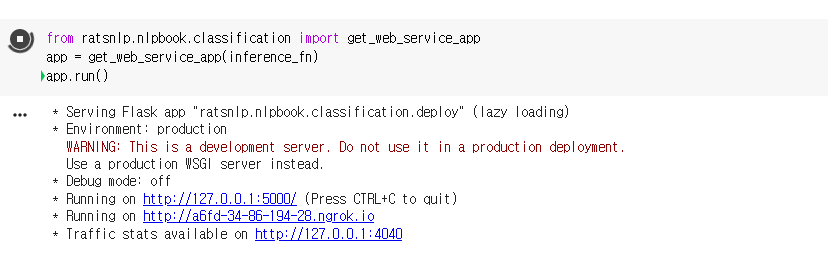

## 웹 사이트의 형태는 다음과 같다.

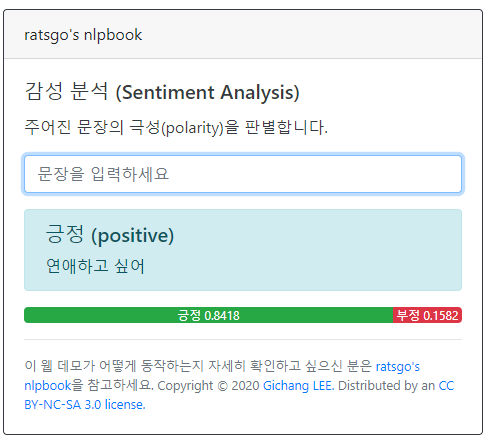